## Analysis of toronto neighborhoods to find the best place to open a new gym place
### ----------------------------------------------------------------------------------------------------------------------------------------------


In [1]:
#Importing Libraries 
import bs4
import pandas as pd
from bs4 import BeautifulSoup as bs4
import requests
import numpy as np
import folium
import json
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans


In [2]:
url= requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text

In [3]:
soup = bs4(url,'lxml')
print(soup)


<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
<head>
<meta charset="utf-8"/>
<title>List of postal codes of Canada: M - Wikipedia</title>
<script>document.documentElement.className=document.documentElement.className.replace(/(^|\s)client-nojs(\s|$)/,"$1client-js$2");RLCONF={"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"List_of_postal_codes_of_Canada:_M","wgTitle":"List of postal codes of Canada: M","wgCurRevisionId":906439794,"wgRevisionId":906439794,"wgArticleId":539066,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Communications in Ontario","Postal codes in Canada","Toronto","Ontario-related lists"],"wgBreakFrames":!1,"wgPageContentLanguage":"en","wgPageContentModel":"wikitext","wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","S

In [4]:
table=soup.find('table')
table_rows = table.find_all('tr')
data = []
for tr in table_rows:
    td = tr.find_all('td')
    row = [tr.text.strip() for tr in td if tr.text.strip()]
    if row:
        data.append(row)
        
df = pd.DataFrame(data, columns=["PostalCode", "Borough", "Neighbourhood"])
df.head()

,PostalCode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


In [5]:
#removing rows where Borough is 'not assigned'
df=df[df['Borough']!='Not assigned']
df.head()

,PostalCode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights


In [6]:
#If neighbourhood is 'not assigned', then the neighborhood will be the same as the borough
for index, row in df.iterrows():
    if row['Neighbourhood'] == 'Not assigned':
        row['Neighbourhood'] = row['Borough']

In [7]:
df.shape

(211, 3)

In [8]:
# Adding long and Lat to data frame 
geospatial_data = pd.read_csv('http://cocl.us/Geospatial_data')
geospatial_data = geospatial_data.rename(columns={geospatial_data.columns[0]: "PostalCode" })
df=df.merge(geospatial_data, on = 'PostalCode')
df.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636
4,M6A,North York,Lawrence Heights,43.718518,-79.464763


In [9]:
#df=df.drop(["PostalCode",'Latitude_x','Latitude_y','Longitude_x','Longitude_y'],axis=1)
#df=df.drop(['Latitude_x','Latitude_y','Longitude_x','Longitude_y'],axis=1)

#df.head()

## Get Longtitude and Latitude of Toronto

In [10]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


### Create a map of Toronto

In [11]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# adding markers to map
for lat, lng, borough, Neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighbourhood']):
    label = '{}, {}'.format(Neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### Exploring Neighborhoods

#### Define Foursquare Credentials and Version

In [12]:
CLIENT_ID = 'XVGDFLF2C0IF5PV3BXRJIXFWUVSIR5NQ5CY03HV4UKSA4KA2' # your Foursquare ID
CLIENT_SECRET = 'JLSEEKF02Z5VMDG4GUVLFODGV0S1WEOQFAETNP3DHQWNCF2F' # your Foursquare Secret
VERSION = '20190801' # Foursquare API version
City="Toronto,Ontario"
category="4bf58dd8d48988d175941735"
radius=500
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: XVGDFLF2C0IF5PV3BXRJIXFWUVSIR5NQ5CY03HV4UKSA4KA2
CLIENT_SECRET:JLSEEKF02Z5VMDG4GUVLFODGV0S1WEOQFAETNP3DHQWNCF2F


#### create afunction to get the venues for each neighbourhood 

In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            category)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [15]:

toronto_gym_venues = getNearbyVenues(names=df['Neighbourhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )



Parkwoods
Victoria Village
Harbourfront
Regent Park
Lawrence Heights
Lawrence Manor
Queen's Park
Islington Avenue
Rouge
Malvern
Don Mills North
Woodbine Gardens
Parkview Hill
Ryerson
Garden District
Glencairn
Cloverdale
Islington
Martin Grove
Princess Gardens
West Deane Park
Highland Creek
Rouge Hill
Port Union
Flemingdon Park
Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Bloordale Gardens
Eringate
Markland Wood
Old Burnhamthorpe
Guildwood
Morningside
West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor
Downsview North
Wilson Heights
Thorncliffe Park
Adelaide
King
Richmond
Dovercourt Village
Dufferin
Scarborough Village
Fairview
Henry Farm
Oriole
Northwood Park
York University
East Toronto
Harbourfront East
Toronto Islands
Union Station
Little Portugal
Trinity
East Birchmount Park
Ionview
Kennedy Park
Bayview Village
CFB Toronto
Downsview East
The Danforth West
Riverdale
Design E

In [16]:
print(toronto_gym_venues.shape)
toronto_gym_venues.head()

(679, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Harbourfront,43.65426,-79.360636,Toronto Cooper Koo Family Cherry St YMCA Centre,43.653191,-79.357947,Gym / Fitness Center
1,Harbourfront,43.65426,-79.360636,The Extension Room,43.653313,-79.359725,Gym / Fitness Center
2,Harbourfront,43.65426,-79.360636,The Yoga Lounge,43.655515,-79.364955,Yoga Studio
3,Harbourfront,43.65426,-79.360636,Corktown District Lofts Gym,43.655652,-79.358125,Gym
4,Regent Park,43.65426,-79.360636,Toronto Cooper Koo Family Cherry St YMCA Centre,43.653191,-79.357947,Gym / Fitness Center


In [17]:
toronto_gym_venues.to_csv('toronto_gym_venues.csv')

In [18]:
df_test=toronto_gym_venues

In [19]:
toronto_gym_venues['freq']=toronto_gym_venues.groupby('Neighborhood')['Venue Category'].transform('count')

In [20]:
toronto_gym_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,freq
0,Harbourfront,43.65426,-79.360636,Toronto Cooper Koo Family Cherry St YMCA Centre,43.653191,-79.357947,Gym / Fitness Center,4
1,Harbourfront,43.65426,-79.360636,The Extension Room,43.653313,-79.359725,Gym / Fitness Center,4
2,Harbourfront,43.65426,-79.360636,The Yoga Lounge,43.655515,-79.364955,Yoga Studio,4
3,Harbourfront,43.65426,-79.360636,Corktown District Lofts Gym,43.655652,-79.358125,Gym,4
4,Regent Park,43.65426,-79.360636,Toronto Cooper Koo Family Cherry St YMCA Centre,43.653191,-79.357947,Gym / Fitness Center,4


In [21]:
# Filtering the dataframe by deleting un necessary columns 
toronto_gym_venues=toronto_gym_venues.drop(['Venue','Venue Latitude','Venue Longitude','Venue Category'],axis=1)
toronto_gym_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,freq
0,Harbourfront,43.65426,-79.360636,4
1,Harbourfront,43.65426,-79.360636,4
2,Harbourfront,43.65426,-79.360636,4
3,Harbourfront,43.65426,-79.360636,4
4,Regent Park,43.65426,-79.360636,4


In [22]:
# rest the index
df_venues=toronto_gym_venues.groupby('Neighborhood').count().reset_index()

df_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,freq
0,Adelaide,24,24,24
1,Agincourt,3,3,3
2,Agincourt North,1,1,1
3,Alderwood,2,2,2
4,Bathurst Manor,1,1,1


#### Creating a dataframe of the venues if each neighborhood with their coordinates and number of venues 

In [23]:
Neighbourhoods=[]
Longtitudes=[]
Latitude=[]
freq=[]
for n,lat,long in zip(df['Neighbourhood'],df['Latitude'],df['Longitude']):
    x=0
    for m,f in zip(toronto_gym_venues['Neighborhood'],toronto_gym_venues['freq']): 
        if n == m:
            
            Neighbourhoods.append(n)
            Longtitudes.append(long)
            Latitude.append(lat)
            freq.append(f)
            break


   
     
     

    

In [24]:
df_f=pd.DataFrame(data=freq,columns=['freq'])
df_f.count()

freq    119
dtype: int64

In [25]:
df_n=pd.DataFrame(data=Neighbourhoods,columns=['Neighborhood'])
df_n.count()

Neighborhood    119
dtype: int64

In [26]:
df_long=pd.DataFrame(data=Longtitudes,columns=['Neighborhood Longitude'])
df_long.count()

Neighborhood Longitude    119
dtype: int64

In [27]:
df_lat=pd.DataFrame(data=Latitude,columns=['Neighborhood Latitude'])
df_long.count()

Neighborhood Longitude    119
dtype: int64

In [28]:
df_venues_1=df_n.join(df_long)
df_venues_1=df_venues_1.join(df_lat)

df_venues_1=df_venues_1.join(df_f)

df_venues_1.head(10)


,Neighborhood,Neighborhood Longitude,Neighborhood Latitude,freq
0,Harbourfront,-79.360636,43.654260,4
1,Regent Park,-79.360636,43.654260,4
2,Lawrence Heights,-79.464763,43.718518,4
3,Lawrence Manor,-79.464763,43.718518,4
4,Queen's Park,-79.389494,43.662301,11
5,Don Mills North,-79.352188,43.745906,3
6,Woodbine Gardens,-79.309937,43.706397,3
7,Parkview Hill,-79.309937,43.706397,3
8,Ryerson,-79.378937,43.657162,19
9,Garden District,-79.378937,43.657162,19


#### Creating a dataframe of the neighborhood  that does not have gyms

In [29]:

Neighbourhoods=[]
Longtitudes=[]
Latitude=[]
x=0
for n, lat, lon in zip(df['Neighbourhood'],df['Latitude'],df['Longitude']) :
    x=0
    for m in df_venues['Neighborhood']:
        if n != m:
            x=x+1
            
        else:
            x=1
            break
    if x!=1:
        
        Neighbourhoods.append(n)
        Longtitudes.append(lon)
        Latitude.append(lat)

        

In [30]:
Neighbourhoods_df=pd.DataFrame(data=Neighbourhoods,columns=['Neighborhood'])
Neighbourhoods_df.count()

Neighborhood    92
dtype: int64

In [31]:
Longtitudes_df=pd.DataFrame(data=Longtitudes,columns=['Neighborhood Longitude'])
Longtitudes_df.count()

Neighborhood Longitude    92
dtype: int64

In [32]:
Latitude_df=pd.DataFrame(data=Latitude,columns=['Neighborhood Latitude'])
Latitude_df.count()

Neighborhood Latitude    92
dtype: int64

In [33]:
df_no_venues=Neighbourhoods_df.join(Longtitudes_df)
df_no_venues=df_no_venues.join(Latitude_df)


In [34]:

df_no_venues['freq']=0

In [35]:
df_no_venues.head()

,Neighborhood,Neighborhood Longitude,Neighborhood Latitude,freq
0,Parkwoods,-79.329656,43.753259,0
1,Victoria Village,-79.315572,43.725882,0
2,Islington Avenue,-79.532242,43.667856,0
3,Rouge,-79.194353,43.806686,0
4,Malvern,-79.194353,43.806686,0


In [36]:
df_final=df_venues_1.append(df_no_venues)
df_final.head()

,Neighborhood,Neighborhood Longitude,Neighborhood Latitude,freq
0,Harbourfront,-79.360636,43.654260,4
1,Regent Park,-79.360636,43.654260,4
2,Lawrence Heights,-79.464763,43.718518,4
3,Lawrence Manor,-79.464763,43.718518,4
4,Queen's Park,-79.389494,43.662301,11


In [37]:
df_hood=df_final.drop(['Neighborhood Latitude','Neighborhood Longitude','freq'],axis=1)
df_hood.head()

,Neighborhood
0,Harbourfront
1,Regent Park
2,Lawrence Heights
3,Lawrence Manor
4,Queen's Park


#### Applying K-Means Clustering to the data

In [38]:
df_grouped_clustering =df_final.drop(['Neighborhood','Neighborhood Latitude','Neighborhood Longitude'], 1)

In [39]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans = kmeans.fit(df_grouped_clustering)
    Sum_of_squared_distances.append(kmeans.inertia_)

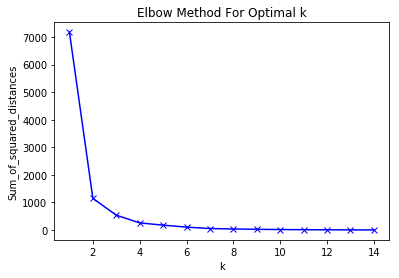

In [41]:
import matplotlib.pyplot as plt
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [42]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0)
kmeans=kmeans.fit(df_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 2, 2, 2, 2, 2, 2, 1, 1])

In [43]:
# add clustering labels
df_hood.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df_final   #df original

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(df_hood.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,Neighborhood,Neighborhood Longitude,Neighborhood Latitude,freq,Cluster Labels
0,Harbourfront,-79.360636,43.654260,4,2
1,Regent Park,-79.360636,43.654260,4,2
2,Lawrence Heights,-79.464763,43.718518,4,2
3,Lawrence Manor,-79.464763,43.718518,4,2
4,Queen's Park,-79.389494,43.662301,11,2


In [44]:
import matplotlib.cm as cm
import matplotlib.colors as colors
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# adding markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Neighborhood Latitude'], toronto_merged['Neighborhood Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters